# Extraction and cleanup of the refugee data

In [94]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shapely.wkt


import folium
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime
from folium import IFrame

In [63]:
CONFLICT_DATA_PATH = "ged171.csv"
raw_conflict_df = pd.read_csv(CONFLICT_DATA_PATH)
display(raw_conflict_df.head(5))

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high
0,4,2010,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2010-09-25,2010-09-25,2,0,0,0,2,2,2
1,5,2011,1,3,715,Government of Yemen (North Yemen) - Civilians,1182,Government of Yemen (North Yemen) - Civilians,123,678.0,...,1,2011-02-19,2011-02-19,0,0,0,0,0,0,2
2,6,2011,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2011-04-16,2011-04-16,0,0,0,0,0,0,1
3,7,2012,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2012-06-04,2012-06-04,4,1,0,0,5,5,5
4,10,2012,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2012-12-09,2012-12-09,0,4,1,0,5,5,5


In [64]:
for year in tqdm(raw_conflict_df.year.unique()):
    for conflict_new_id in raw_conflict_df[raw_conflict_df.year == year].conflict_new_id.unique():
        subdf = raw_conflict_df[(raw_conflict_df.year == year) & (raw_conflict_df.year == year)]

100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


In [65]:
print(raw_conflict_df.columns)

Index(['id', 'year', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'side_b_new_id', 'gwnob', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt', 'priogrid_gid', 'country',
       'country_id', 'region', 'event_clarity', 'date_prec', 'date_start',
       'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown', 'best', 'low', 'high'],
      dtype='object')


In [66]:
# TODO: explain why we keep what
KEPT_COLUMNS= ['id', 'year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'gwnob', 'side_b_new_id','side_b',
       'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt','country',
       'country_id','date_start', 'deaths_a', 'deaths_b',
       'deaths_civilians',
       'deaths_unknown', 'best'] 

In [67]:
conflict_df = raw_conflict_df[KEPT_COLUMNS]

In [68]:
conflict_df = conflict_df.replace(to_replace="-[0-9]{2}-[0-9]{2}", value="", regex=True)

In [69]:
conflict_df.head(5)

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,longitude,geom_wkt,country,country_id,date_start,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,44.206667,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2,0,0,0,2
1,5,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,45.036667,POINT (45.036667 12.779444),Yemen (North Yemen),678,2011,0,0,0,0,0
2,6,2011,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,46.141765,POINT (46.141765 13.786202),Yemen (North Yemen),678,2011,0,0,0,0,0
3,7,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,46.141765,POINT (46.141765 13.786202),Yemen (North Yemen),678,2012,4,1,0,0,5
4,10,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,45.300000,POINT (45.300000 15.616667),Yemen (North Yemen),678,2012,0,4,1,0,5


In [70]:
with open('conflict.pickle', 'wb') as out:
    pickle.dump(conflict_df, out)

In [71]:
with open('conflict.pickle', 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [72]:
geometry = conflict_df['geom_wkt'].map(shapely.wkt.loads)
conflict_df = conflict_df.drop('geom_wkt', axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(conflict_df, crs=crs, geometry=geometry)


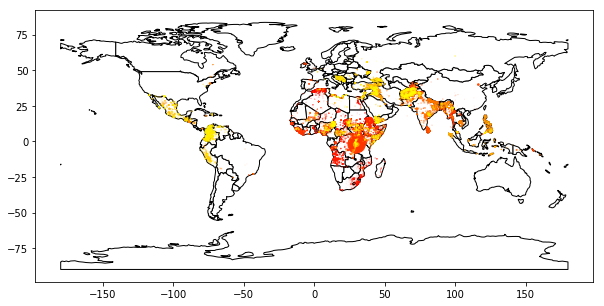

In [73]:
#for row in list(gdf.index.values):
#    print(gdf.get_value(row,"best"))
#    gdf[row].plot(s=gdf.get_value(row, "best"))
#    break
fig, ax = plt.subplots(figsize=(10,5))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=(gdf.loc[:, "best"]/1000), cmap="autumn")
    
plt.show()

In [74]:
m = folium.Map(tiles='cartodbpositron')

In [75]:
geojson_gdf = gdf[:10].to_crs(epsg='4326').to_json()
points = folium.features.GeoJson(geojson_gdf)
m.add_child(points)

In [76]:
table = """
<!DOCTYPE html>
<html>
<head>
<style>
table {{
    width:100%;
}}
table, th, td {{
    border: 1px solid black;
    border-collapse: collapse;
}}
th, td {{
    padding: 5px;
    text-align: left;
}}
table#t01 tr:nth-child(odd) {{
    background-color: #eee;
}}
table#t01 tr:nth-child(even) {{
   background-color:#fff;
}}
</style>
</head>
<body>

<table id="t01">
  <tr>
    <td>Type</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Name</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Nbr</td>
    <td>{}</td>
  </tr>
</table>
</body>
</html>
""".format

In [77]:
m = folium.Map(tiles='cartodbpositron')

In [78]:
#print("Rows to parse:{}".format(len(gdf)))

#width, height = 310,110
#popups, locations = [], []
#for idx, row in tqdm(gdf.iterrows()):
#    locations.append([row['geometry'].y, row['geometry'].x])
#    name = row['conflict_name'].encode('ascii', 'xmlcharrefreplace')
#    deaths = row['best']
#    iframe = folium.IFrame(table('Deaths', name, deaths), width=width, height=height)
#    popups.append(iframe)


0it [00:00, ?it/s]

Rows to parse:135181


135181it [04:17, 525.95it/s]


In [79]:
#h = folium.FeatureGroup(name='Deaths')
#h.add_child(FastMarkerCluster(locations))
#m.add_child(h)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [80]:
#m

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Attempt at creating heatmap layer

In [124]:
with open('country_human_cost.pickle', 'rb') as data_source:
    country_human_cost_df = pickle.load(data_source)

In [126]:
display(conflict_df.head(1))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,longitude,country,country_id,date_start,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,geometry
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,44.206667,Yemen (North Yemen),678,2010,2,0,0,0,2,POINT (44.206667 15.354722)


In [127]:
event_list = conflict_df[["latitude", "longitude", "best", "date_start"]]
display(event_list.head(2))

,latitude,longitude,best,date_start
0,15.354722,44.206667,2,2010
1,12.779444,45.036667,0,2011


In [118]:
event_list = event_list.sort_values("date_start")
list_of_event= [[row.latitude, row.longitude, row.best] for row in event_list.itertuples()]

In [119]:
m = folium.Map(tiles='stamentoner', world_copy_jump = True, no_wrap=True)

In [120]:
list_of_date = [row.date_start for row in event_list.itertuples()]

In [121]:
hm = HeatMapWithTime(data=list_of_event[:10000], index=list_of_date[:10000])

In [122]:
hm.add_to(m)

In [123]:
m